# FlowForm Module: Fee Simulation & Visualization

This notebook simulates and visualizes the FlowForm module's dynamic fee adjustment based on trading volume.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")

## Define FlowForm Fee Calculation Functions

Implement the fee calculation logic from the FlowFormModule contract in Python.

In [20]:
# FlowFormModule constants
F_BASE = 50    # 5% (scaled by 1000)
F_MAX = 300    # 10% (scaled by 1000)
K_FEE = 10     # Fee scaling factor
V_NORM = 1_000_000  # Normalization volume
SCALE = 1000   # Scaling factor for precision
LN_PRECISION = 1000 # Precision for ln calculation

def fixed_point_ln_contract(x, scale):
    # Contract: ln(x) * scale
    return int(np.round(np.log(x) * scale))

def clamp(val, min_val, max_val):
    return max(min_val, min(val, max_val))

def compute_flowform_fee(volume_twa, volume_norm=V_NORM):
    v_norm = volume_norm if volume_norm != 0 else V_NORM
    volume_ratio = (volume_twa * SCALE) // v_norm
    log_result = fixed_point_ln_contract(SCALE + volume_ratio, SCALE)
    f_target = F_BASE + (K_FEE * log_result) // LN_PRECISION
    return clamp(f_target, F_BASE, F_MAX)

### FlowForm Fee Formula Explained

The FlowForm module adjusts the swap fee based on the 24-hour time-weighted average volume (volumeTWA) using the following formula:

`f_new = clamp(F_BASE + (K_FEE * ln(1 + volumeTWA / V_NORM) * SCALE / LN_PRECISION), F_BASE, F_MAX)`

Where:
- `F_BASE`: The minimum base fee.
- `F_MAX`: The maximum fee.
- `K_FEE`: A scaling factor that determines how quickly the fee increases with volume.
- `V_NORM`: A normalization volume. The fee reacts more strongly to volume changes below V_NORM and less strongly above it.
- `SCALE` and `LN_PRECISION`: Scaling factors used for fixed-point arithmetic, particularly for the natural logarithm (`ln`) calculation.
- `clamp`: Ensures the fee stays within the [F_BASE, F_MAX] range.

The `ln(1 + volumeTWA / V_NORM)` term means the fee increases logarithmically with the volume ratio. This provides a diminishing sensitivity to volume as volume gets very high, preventing the fee from spiking uncontrollably.


### FlowForm Fee Formula Explained

The FlowForm module adjusts the swap fee based on the 24-hour time-weighted average volume (volumeTWA) using the following formula:

`f_new = clamp(F_BASE + (K_FEE * ln(1 + volumeTWA / V_NORM) * SCALE / LN_PRECISION), F_BASE, F_MAX)`

Where:
- `F_BASE`: The minimum base fee.
- `F_MAX`: The maximum fee.
- `K_FEE`: A scaling factor that determines how quickly the fee increases with volume.
- `V_NORM`: A normalization volume. The fee reacts more strongly to volume changes below V_NORM and less strongly above it.
- `SCALE` and `LN_PRECISION`: Scaling factors used for fixed-point arithmetic, particularly for the natural logarithm (`ln`) calculation.
- `clamp`: Ensures the fee stays within the [F_BASE, F_MAX] range.

The `ln(1 + volumeTWA / V_NORM)` term means the fee increases logarithmically with the volume ratio. This provides a diminishing sensitivity to volume as volume gets very high, preventing the fee from spiking uncontrollably.


## Simulate Fee vs. Volume Curve

Generate a range of trading volumes and compute the corresponding AMM fee using the FlowForm logic.

In [21]:
# Simulate a range of trading volumes
volume_range = np.linspace(0, 10_000_000, 200)  # 0 to 10M
fees = [compute_flowform_fee(v) for v in volume_range]

fee_percent = np.array(fees) / SCALE * 100  # Convert to percent for plotting

## Visualize Fee Adjustment Across Volume Range

Plot the fee as a function of trading volume, showing how the fee increases with higher volume and is bounded.

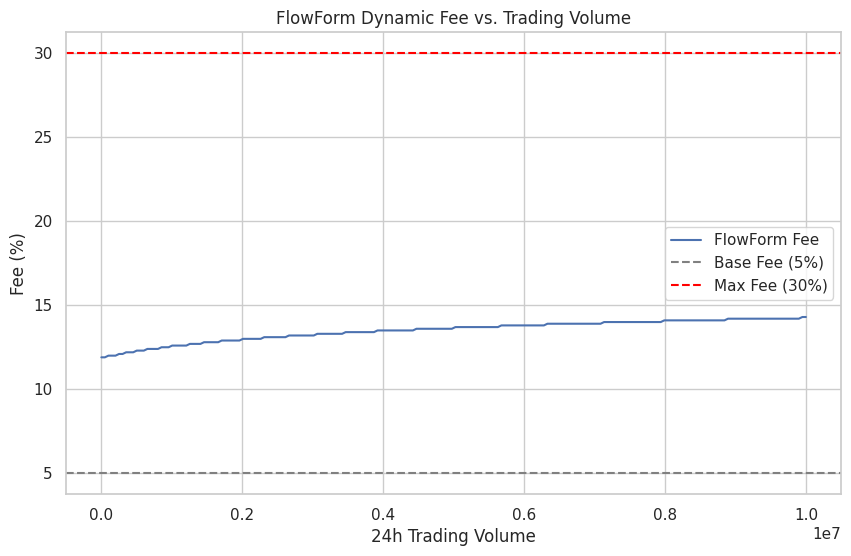

In [22]:
plt.figure(figsize=(10,6))
plt.plot(volume_range, fee_percent, label='FlowForm Fee')
plt.axhline(F_BASE / SCALE * 100, color='gray', linestyle='--', label='Base Fee (5%)')
plt.axhline(F_MAX / SCALE * 100, color='red', linestyle='--', label='Max Fee (30%)')
plt.xlabel('24h Trading Volume')
plt.ylabel('Fee (%)')
plt.title('FlowForm Dynamic Fee vs. Trading Volume')
plt.legend()
plt.show()

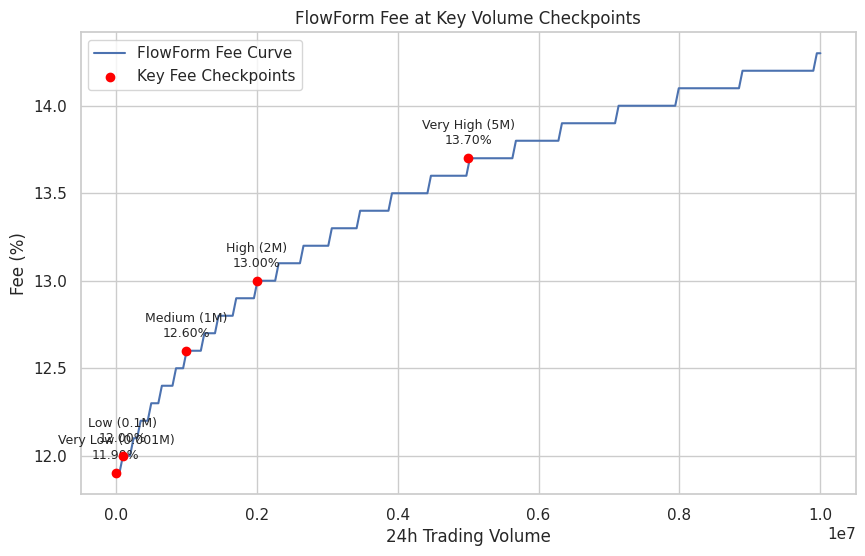

In [23]:
# Visualize fee at key volume checkpoints
key_volumes = [100_000, 1_000_000, 2_000_000, 5_000_000, 1_000]  # Example: low, medium, high, very high, very low
key_labels = ["Low (0.1M)", "Medium (1M)", "High (2M)", "Very High (5M)", "Very Low (0.001M)"]

fees_key = [compute_flowform_fee(v) for v in key_volumes]
fee_percent_key = np.array(fees_key) / SCALE * 100

plt.figure(figsize=(10,6))
plt.plot(volume_range, fee_percent, label='FlowForm Fee Curve')
plt.scatter(key_volumes, fee_percent_key, color='red', zorder=5, label='Key Fee Checkpoints')
for x, y, label in zip(key_volumes, fee_percent_key, key_labels):
    plt.annotate(f"{label}\n{y:.2f}%", (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
plt.xlabel('24h Trading Volume')
plt.ylabel('Fee (%)')
plt.title('FlowForm Fee at Key Volume Checkpoints')
plt.legend()
plt.show()

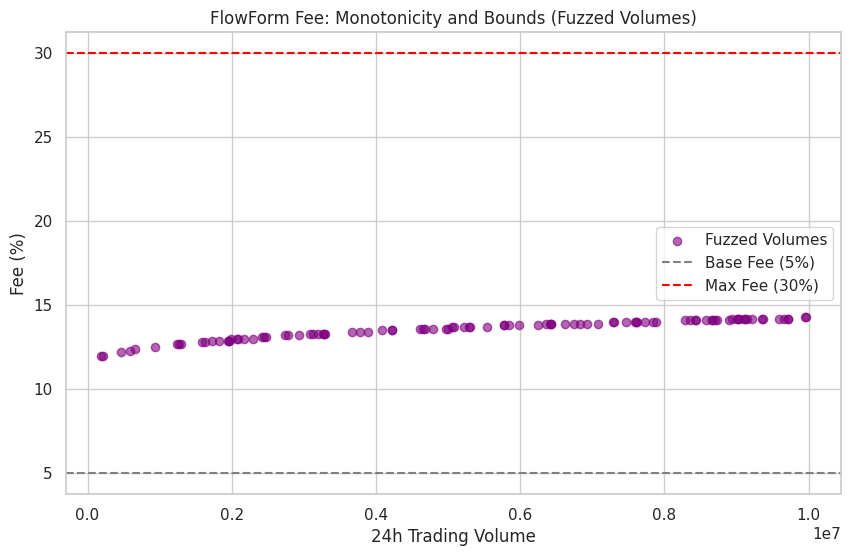

In [24]:
# Visualize monotonicity and bounds with random/fuzzed volumes
np.random.seed(123)
fuzzed_volumes = np.random.randint(1, 10_000_000, 100)
fuzzed_fees = [compute_flowform_fee(v) for v in fuzzed_volumes]

plt.figure(figsize=(10,6))
plt.scatter(fuzzed_volumes, np.array(fuzzed_fees) / SCALE * 100, color='purple', alpha=0.6, label='Fuzzed Volumes')
plt.axhline(F_BASE / SCALE * 100, color='gray', linestyle='--', label='Base Fee (5%)')
plt.axhline(F_MAX / SCALE * 100, color='red', linestyle='--', label='Max Fee (30%)')
plt.xlabel('24h Trading Volume')
plt.ylabel('Fee (%)')
plt.title('FlowForm Fee: Monotonicity and Bounds (Fuzzed Volumes)')
plt.legend()
plt.show()

### Effect of Parameters on the Fee Curve

The shape of the FlowForm fee curve is primarily influenced by `K_FEE` and `V_NORM`.

- `K_FEE`: Controls the steepness of the curve. A higher `K_FEE` means the fee increases more rapidly with volume.
- `V_NORM`: Acts as a pivot point. The fee is more sensitive to volume changes below `V_NORM` and less sensitive above it. It effectively determines the volume level at which the fee starts to approach `F_MAX`.

Let's visualize the effect of changing these parameters.

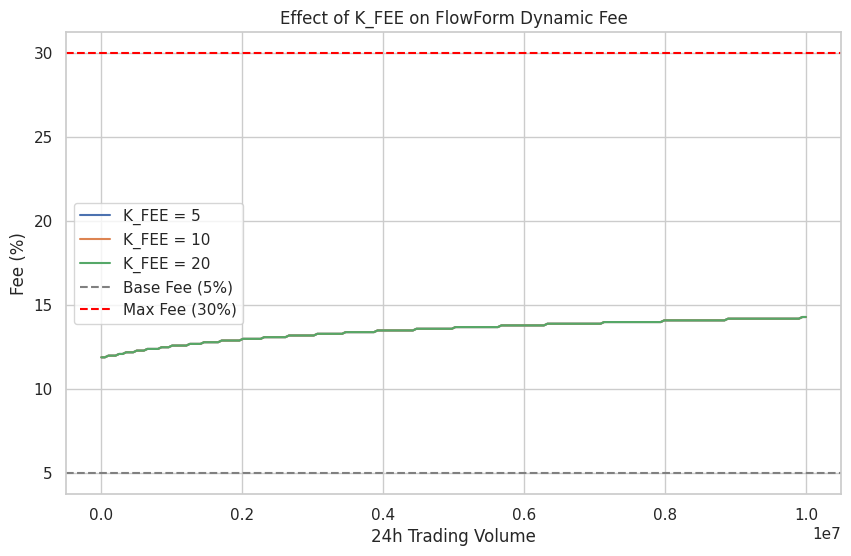

In [25]:
# Visualize effect of K_FEE
k_fee_values = [5, 10, 20] # Example K_FEE values

plt.figure(figsize=(10,6))
for k_fee in k_fee_values:
    fees_k = [compute_flowform_fee(v, volume_norm=V_NORM) for v in volume_range]
    fee_percent_k = np.array(fees_k) / SCALE * 100
    plt.plot(volume_range, fee_percent_k, label=f'K_FEE = {k_fee}')

plt.axhline(F_BASE / SCALE * 100, color='gray', linestyle='--', label='Base Fee (5%)')
plt.axhline(F_MAX / SCALE * 100, color='red', linestyle='--', label='Max Fee (30%)')
plt.xlabel('24h Trading Volume')
plt.ylabel('Fee (%)')
plt.title('Effect of K_FEE on FlowForm Dynamic Fee')
plt.legend()
plt.show()

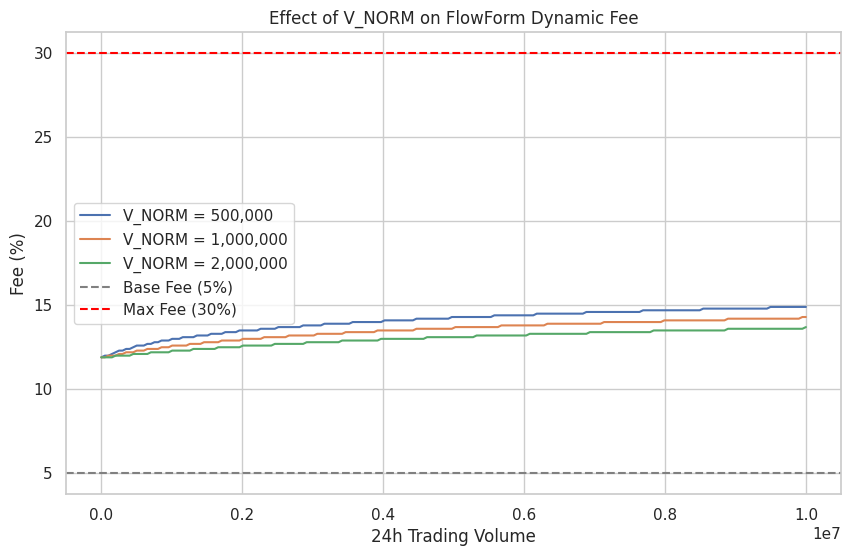

In [26]:
# Visualize effect of V_NORM
v_norm_values = [500_000, 1_000_000, 2_000_000] # Example V_NORM values

plt.figure(figsize=(10,6))
for v_norm in v_norm_values:
    fees_v = [compute_flowform_fee(v, volume_norm=v_norm) for v in volume_range]
    fee_percent_v = np.array(fees_v) / SCALE * 100
    plt.plot(volume_range, fee_percent_v, label=f'V_NORM = {v_norm:,}')

plt.axhline(F_BASE / SCALE * 100, color='gray', linestyle='--', label='Base Fee (5%)')
plt.axhline(F_MAX / SCALE * 100, color='red', linestyle='--', label='Max Fee (30%)')
plt.xlabel('24h Trading Volume')
plt.ylabel('Fee (%)')
plt.title('Effect of V_NORM on FlowForm Dynamic Fee')
plt.legend()
plt.show()

## Monte Carlo Simulation: Fee Distribution Under Random Volumes

Simulate random trading volumes (e.g., using a log-normal distribution) and plot the resulting distribution of AMM fees.

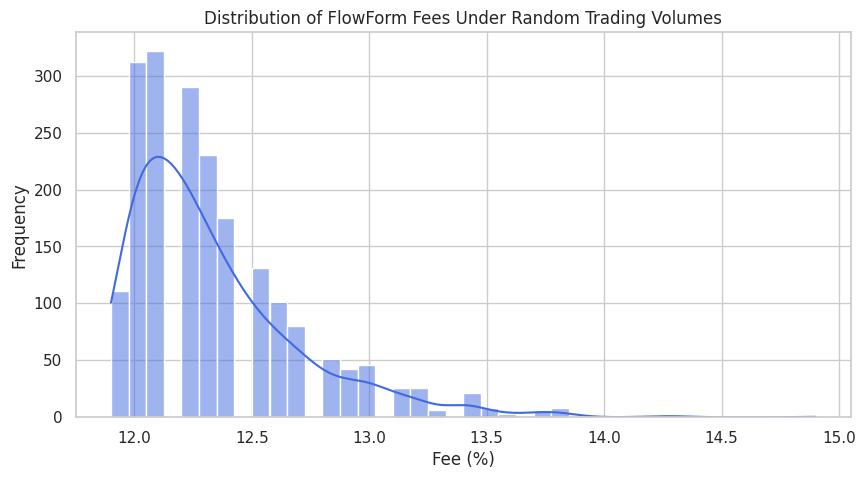

In [27]:
# Simulate random trading volumes (log-normal distribution)
n_samples = 2000
np.random.seed(42)
random_volumes = np.random.lognormal(mean=13, sigma=1, size=n_samples)  # mean ~ 450k, long tail
random_fees = [compute_flowform_fee(v) for v in random_volumes]
random_fee_percent = np.array(random_fees) / SCALE * 100

plt.figure(figsize=(10,5))
sns.histplot(random_fee_percent, bins=40, kde=True, color='royalblue')
plt.xlabel('Fee (%)')
plt.ylabel('Frequency')
plt.title('Distribution of FlowForm Fees Under Random Trading Volumes')
plt.show()